# Import Modules

In [ ]:
import os
import numpy as np
from glob import glob
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet_v2 import preprocess_input, ResNet50V2

/home/aivn24/Khoa/tensorflow_venv/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
np.random.seed(99)

# Baseline Model

## Config and Load Data

In [ ]:
BATCH_SIZE = 128
IMG_HEGIHT  = 256
IMG_WIDHT   = 256
IMG_CHANNEL = 3
BUFFER_SIZE = BATCH_SIZE*5
MODEL_PATH = "/media/aivn24/partition2/Khoa/AI2021/imbalanced_classification/Exercise/covid19_classification_models"
TRAIN_PATH = "/media/aivn24/partition2/Khoa/AI2021/imbalanced_classification/Exercise/covid19_classification_dataset/train"
VAL_PATH = "/media/aivn24/partition2/Khoa/AI2021/imbalanced_classification/Exercise/covid19_classification_dataset/val"
# CC_PATH = "/media/aivn24/partition2/Khoa/AI2021/imbalanced_classification/Exercise/gender-classification-dataset/cc"
CLASS_DICT = {
    'COVID':1,
    'NORMAL':0
}
rot_layer = tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)

In [ ]:
def load(image_path, label):
    
    image   = tf.io.read_file(image_path)
    image   = tf.image.decode_png(image, channels=IMG_CHANNEL)
    
    image  = tf.image.resize(image, (IMG_HEGIHT, IMG_WIDHT))
    
    # Convert both images to float32 tensors
    image  = tf.cast(image, tf.float32)
    
    return image, label

(256, 256, 3)


2022-03-25 23:41:30.818761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 23:41:30.824549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 23:41:30.825283: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 23:41:30.826217: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

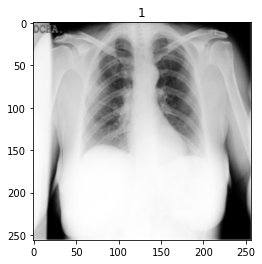

In [ ]:
test_image, label = load(os.path.join(TRAIN_PATH, "COVID/COVID-1021.png"), CLASS_DICT['COVID'])
print(test_image.shape)


# casting to int for matplotlib to show the image
plt.figure()
plt.title(label)
plt.imshow(test_image/255.0)

In [ ]:
@tf.function()
def random_flip(image):
#     if tf.random.uniform(()) > 0.5:
#         # Random mirroring
#         image  = tf.image.flip_left_right(image)

#     image = tf.keras.preprocessing.image.random_rotation(image, rg=(-20, 20))
#     image = rot_layer(image)
    return image


def processing_image(image):    
    image  =  preprocess_input(image) 
    return image


def load_image_train(image, label):
    image, label = load(image, label)
    image = random_flip(image)
    image = processing_image(image)

    return image, label


def load_image_val(image, label):
    image, label = load(image, label)
    image = processing_image(image)

    return image, label

In [ ]:
def get_img_path_and_labels(path, num_pos, num_neg=-1):
    pos_paths = np.array(glob(path + f'/{list(CLASS_DICT.keys())[0]}/*.png'))
    neg_paths = np.array(glob(path + f'/{list(CLASS_DICT.keys())[1]}/*.png'))
    
    assert (num_pos >= -1), f'Incorrect num_pos {num_pos}'
    assert (num_neg >= -1), f'Incorrect num_neg {num_neg}'
    if num_pos != -1:
        pos_paths = pos_paths[:num_pos]
    if num_neg != -1:
        neg_paths = neg_paths[:num_neg]
    image_paths = np.append(pos_paths, neg_paths)
    labels = np.array([CLASS_DICT[os.path.basename(os.path.dirname(im_p))] for im_p in image_paths])    
        
    print("TOTAL SAMPLES: ", len(image_paths))
    print('POSSITVE CLASS: ', sum(np.array(labels)==1))
    print('NEGATIVE CLASS: ', sum(np.array(labels)==0))
    idx = np.arange(len(labels))
    np.random.shuffle(idx)
    return image_paths[idx], labels[idx]

In [ ]:
train_imgs_path = get_img_path_and_labels(TRAIN_PATH, num_pos=-1)
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs_path[0], train_imgs_path[1]))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  9778
POSSITVE CLASS:  586
NEGATIVE CLASS:  9192


In [ ]:
val_imgs_path = get_img_path_and_labels(VAL_PATH, num_pos=-1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs_path[0],val_imgs_path[1]))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  2000
POSSITVE CLASS:  1000
NEGATIVE CLASS:  1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


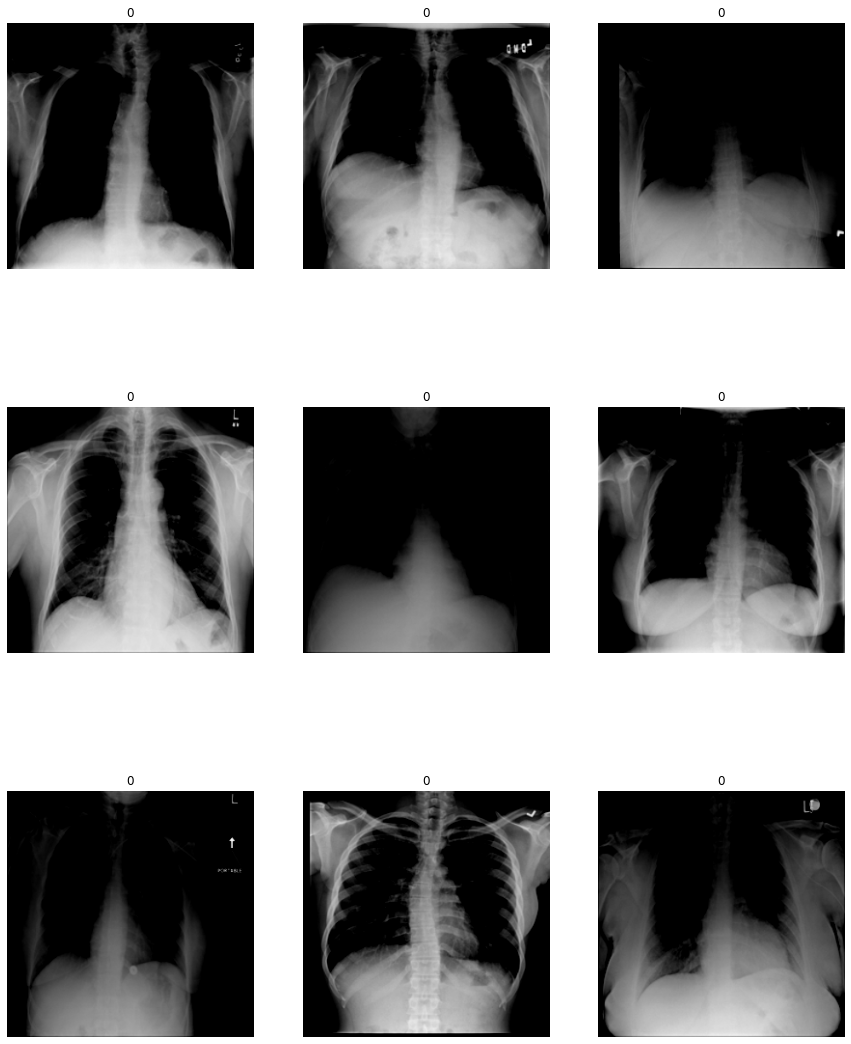

In [ ]:
for ims, las in train_dataset.take(1):
    plt.figure(figsize=(15,20))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.title(las[i].numpy())
        plt.imshow(ims[i])
        plt.axis('off')
    plt.show() 

## Build Model 

In [ ]:
def build_model(input_shape, final_act=None, weights=None):
    # Create the base model from the pre-trained model MobileNet V2
    base_model = ResNet50V2(input_shape=input_shape,
                                         include_top=False,
                                          weights=weights)
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    if final_act is not None:
        prediction_layer = tf.keras.layers.Dense(1, activation=final_act)
    else:
        prediction_layer = tf.keras.layers.Dense(1)
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs)
    x = global_average_layer(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
baseline_model = build_model(input_shape= (IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL), final_act='sigmoid')

## Compile and Train 

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
base_learning_rate = 0.0001
baseline_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(base_learning_rate),
              metrics=METRICS)

In [ ]:
baseline_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
len(baseline_model.trainable_variables)

174

In [ ]:
baseline_model_history = baseline_model.fit(train_dataset,
                         epochs=50,
                         validation_data=val_dataset)

Epoch 1/50


2022-03-25 23:41:35.144823: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-03-25 23:41:36.726680: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


77/77 [==============================] - 39s 430ms/step - loss: 0.1882 - tp: 135.0000 - fp: 203.0000 - tn: 8989.0000 - fn: 451.0000 - accuracy: 0.9331 - precision: 0.3994 - recall: 0.2304 - auc: 0.8455 - prc: 0.3025 - val_loss: 1.4516 - val_tp: 1000.0000 - val_fp: 1000.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.6686 - val_prc: 0.7104
Epoch 2/50
77/77 [==============================] - 32s 409ms/step - loss: 0.0857 - tp: 362.0000 - fp: 56.0000 - tn: 9136.0000 - fn: 224.0000 - accuracy: 0.9714 - precision: 0.8660 - recall: 0.6177 - auc: 0.9664 - prc: 0.8126 - val_loss: 2.4582 - val_tp: 1000.0000 - val_fp: 1000.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.3869 - val_prc: 0.4522
Epoch 3/50
77/77 [==============================] - 30s 385ms/step - loss: 0.0507 - tp: 463.0000 - fp: 43.0000 - tn: 9149.0000 - fn: 123.0000 - accu

Epoch 39/50
77/77 [==============================] - 32s 409ms/step - loss: 2.1940e-05 - tp: 586.0000 - fp: 0.0000e+00 - tn: 9192.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.5041 - val_tp: 776.0000 - val_fp: 3.0000 - val_tn: 997.0000 - val_fn: 224.0000 - val_accuracy: 0.8865 - val_precision: 0.9961 - val_recall: 0.7760 - val_auc: 0.9580 - val_prc: 0.9721
Epoch 40/50
77/77 [==============================] - 32s 415ms/step - loss: 2.5506e-05 - tp: 586.0000 - fp: 0.0000e+00 - tn: 9192.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.5074 - val_tp: 777.0000 - val_fp: 3.0000 - val_tn: 997.0000 - val_fn: 223.0000 - val_accuracy: 0.8870 - val_precision: 0.9962 - val_recall: 0.7770 - val_auc: 0.9575 - val_prc: 0.9718
Epoch 41/50
77/77 [==============================] - 32s 418ms/step - loss: 2.2645e-05 - tp: 586.0000 - fp: 0.0000e+00 - tn: 9192.0000

In [ ]:
baseline_model.save(os.path.join(MODEL_PATH, 'baseline_model.h5'))

## Evaluate Models 

In [ ]:
def show_results(history, name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Training and Validation Accuracy {name}')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Training and Validation Loss {name}')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
def get_correct_results(model, dataset):
    total_correct_pos = 0
    total_correct_neg = 0
    total_correct = 0

    for x,y in dataset:    
        y = tf.dtypes.cast(y, tf.int32)
        output = model.predict(x)

        prediction = output > 0.5   
        prediction = tf.dtypes.cast(prediction, tf.int32)

        correct_pre = prediction[:,0] == y
        correct_pre = tf.dtypes.cast(correct_pre, tf.int32)

        # accumulate
        total_correct = total_correct + tf.math.reduce_sum(correct_pre)
        total_correct_pos = total_correct_pos + tf.math.reduce_sum(correct_pre[y==1])
        total_correct_neg = total_correct_neg + tf.math.reduce_sum(correct_pre[y==0])

    print('total_correct: ', total_correct)
    print('total_correct_pos: ', total_correct_pos)
    print('total_correct_neg: ', total_correct_neg)

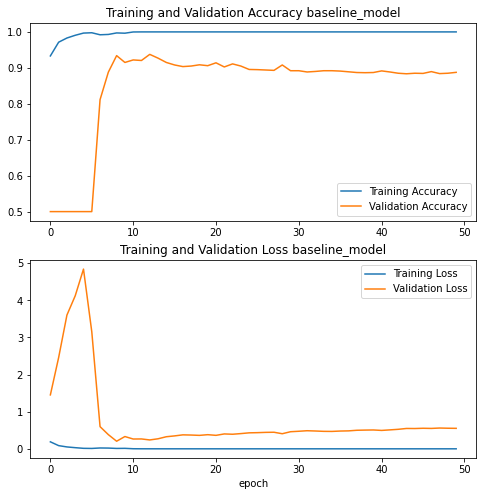

In [ ]:
show_results(baseline_model_history, name='baseline_model')

In [ ]:
get_correct_results(baseline_model, val_dataset)

total_correct:  tf.Tensor(1775, shape=(), dtype=int32)
total_correct_pos:  tf.Tensor(778, shape=(), dtype=int32)
total_correct_neg:  tf.Tensor(997, shape=(), dtype=int32)


# Classweight Imbalanced Data

## Config and Load Data

In [ ]:
train_imgs_path = get_img_path_and_labels(TRAIN_PATH, num_pos=-1)
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs_path[0], train_imgs_path[1]))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  9778
POSSITVE CLASS:  586
NEGATIVE CLASS:  9192


In [ ]:
val_imgs_path = get_img_path_and_labels(VAL_PATH, num_pos=-1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs_path[0],val_imgs_path[1]))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  2000
POSSITVE CLASS:  1000
NEGATIVE CLASS:  1000


## Build Model 

In [ ]:
cw_ibm_model = build_model(input_shape= (IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL), final_act='sigmoid')

## Compile and Train 

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = 586+9192
weight_for_0 = (1 / 9192.0) * (total / 2.0)
weight_for_1 = (1 / 586.0) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.53
Weight for class 1: 8.34


In [ ]:
base_learning_rate = 0.0001
cw_ibm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(base_learning_rate),
              metrics=METRICS)

In [ ]:
cw_ibm_model_history = cw_ibm_model.fit(train_dataset,
                         epochs=50,
                         validation_data=val_dataset,
                         class_weight=class_weight)

Epoch 1/50
77/77 [==============================] - 32s 389ms/step - loss: 0.4290 - tp: 492.0000 - fp: 2079.0000 - tn: 7113.0000 - fn: 94.0000 - accuracy: 0.7778 - precision: 0.1914 - recall: 0.8396 - auc: 0.8873 - prc: 0.4071 - val_loss: 2.1080 - val_tp: 1000.0000 - val_fp: 1000.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.6155 - val_prc: 0.5759
Epoch 2/50
77/77 [==============================] - 30s 388ms/step - loss: 0.2673 - tp: 523.0000 - fp: 975.0000 - tn: 8217.0000 - fn: 63.0000 - accuracy: 0.8938 - precision: 0.3491 - recall: 0.8925 - auc: 0.9564 - prc: 0.7096 - val_loss: 3.4441 - val_tp: 1000.0000 - val_fp: 1000.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5000
Epoch 3/50
77/77 [==============================] - 30s 392ms/step - loss: 0.2021 - tp: 541.0000 - fp: 784.0000 - tn: 8408.0000 - fn: 45.

Epoch 39/50
77/77 [==============================] - 29s 380ms/step - loss: 6.0407e-05 - tp: 586.0000 - fp: 0.0000e+00 - tn: 9192.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.4046 - val_tp: 811.0000 - val_fp: 7.0000 - val_tn: 993.0000 - val_fn: 189.0000 - val_accuracy: 0.9020 - val_precision: 0.9914 - val_recall: 0.8110 - val_auc: 0.9711 - val_prc: 0.9785
Epoch 40/50
77/77 [==============================] - 29s 380ms/step - loss: 6.8377e-05 - tp: 586.0000 - fp: 0.0000e+00 - tn: 9192.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.3985 - val_tp: 815.0000 - val_fp: 7.0000 - val_tn: 993.0000 - val_fn: 185.0000 - val_accuracy: 0.9040 - val_precision: 0.9915 - val_recall: 0.8150 - val_auc: 0.9710 - val_prc: 0.9785
Epoch 41/50
77/77 [==============================] - 29s 380ms/step - loss: 5.2380e-05 - tp: 586.0000 - fp: 0.0000e+00 - tn: 9192.0000

In [ ]:
cw_ibm_model.save(os.path.join(MODEL_PATH, 'cw_ibm_model.h5'))

## Evaluate Models 

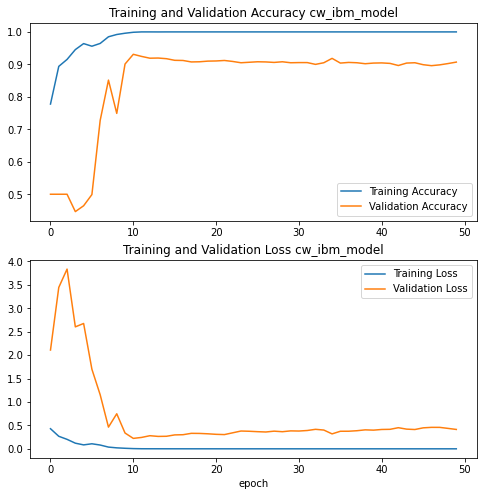

In [ ]:
show_results(cw_ibm_model_history, name='cw_ibm_model')

In [ ]:
get_correct_results(cw_ibm_model, val_dataset)

total_correct:  tf.Tensor(1814, shape=(), dtype=int32)
total_correct_pos:  tf.Tensor(820, shape=(), dtype=int32)
total_correct_neg:  tf.Tensor(994, shape=(), dtype=int32)


# Undersample Imbalanced Data

## Config and Load Data

In [ ]:
train_imgs_path = get_img_path_and_labels(TRAIN_PATH, num_pos=-1,  num_neg=586)
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs_path[0], train_imgs_path[1]))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  1172
POSSITVE CLASS:  586
NEGATIVE CLASS:  586


In [ ]:
val_imgs_path = get_img_path_and_labels(VAL_PATH, num_pos=-1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs_path[0],val_imgs_path[1]))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  2000
POSSITVE CLASS:  1000
NEGATIVE CLASS:  1000


## Build Model 

In [ ]:
u_imb_model = build_model(input_shape= (IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL))

## Compile and Train 

In [ ]:
base_learning_rate = 0.0001
u_imb_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(base_learning_rate),
              metrics=['accuracy'])

In [ ]:
u_imb_model_history = u_imb_model.fit(train_dataset,
                         epochs=50,
                         validation_data=val_dataset)

Epoch 1/50
10/10 [==============================] - 7s 602ms/step - loss: 0.6284 - accuracy: 0.6331 - val_loss: 0.7022 - val_accuracy: 0.5000
Epoch 2/50
10/10 [==============================] - 5s 500ms/step - loss: 0.4191 - accuracy: 0.8148 - val_loss: 0.7794 - val_accuracy: 0.5000
Epoch 3/50
10/10 [==============================] - 5s 501ms/step - loss: 0.3150 - accuracy: 0.8473 - val_loss: 0.9937 - val_accuracy: 0.5000
Epoch 4/50
10/10 [==============================] - 5s 499ms/step - loss: 0.2213 - accuracy: 0.9053 - val_loss: 1.1626 - val_accuracy: 0.5000
Epoch 5/50
10/10 [==============================] - 5s 500ms/step - loss: 0.1579 - accuracy: 0.9437 - val_loss: 1.8538 - val_accuracy: 0.5000
Epoch 6/50
10/10 [==============================] - 5s 499ms/step - loss: 0.1020 - accuracy: 0.9539 - val_loss: 2.6013 - val_accuracy: 0.5000
Epoch 7/50
10/10 [==============================] - 5s 500ms/step - loss: 0.0925 - accuracy: 0.9633 - val_loss: 3.7161 - val_accuracy: 0.5000
Epoch 

In [ ]:
u_imb_model.save(os.path.join(MODEL_PATH, 'u_imb_model.h5'))

## Evaluate Models 

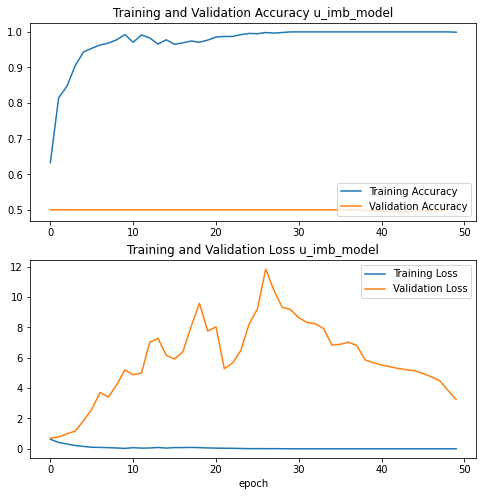

In [ ]:
show_results(u_imb_model_history, name='u_imb_model')

In [ ]:
get_correct_results(u_imb_model, val_dataset)

total_correct:  tf.Tensor(1024, shape=(), dtype=int32)
total_correct_pos:  tf.Tensor(931, shape=(), dtype=int32)
total_correct_neg:  tf.Tensor(93, shape=(), dtype=int32)


# Focal Loss Imbalanced Data

## Config and Load Data

In [ ]:
train_imgs_path = get_img_path_and_labels(TRAIN_PATH, num_pos=-1)
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs_path[0], train_imgs_path[1]))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  9778
POSSITVE CLASS:  586
NEGATIVE CLASS:  9192


In [ ]:
val_imgs_path = get_img_path_and_labels(VAL_PATH, num_pos=-1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs_path[0],val_imgs_path[1]))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  2000
POSSITVE CLASS:  1000
NEGATIVE CLASS:  1000


## Build Model 

In [ ]:
fc_imb_model = build_model(input_shape= (IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL), final_act='sigmoid')

## Compile and Train 

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [ ]:
base_learning_rate = 0.0001
loss_func = tfa.losses.SigmoidFocalCrossEntropy()

fc_imb_model.compile(loss=loss_func,
              optimizer = tf.keras.optimizers.Adam(base_learning_rate),
              metrics=METRICS)

In [ ]:
fc_imb_model_history = fc_imb_model.fit(train_dataset,
                         epochs=50,
                         validation_data=val_dataset)

Epoch 1/50
77/77 [==============================] - 33s 399ms/step - loss: 0.0236 - tp: 64.0000 - fp: 199.0000 - tn: 8993.0000 - fn: 522.0000 - accuracy: 0.9263 - precision: 0.2433 - recall: 0.1092 - auc: 0.8089 - prc: 0.2056 - val_loss: 0.2953 - val_tp: 1000.0000 - val_fp: 1000.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.6400 - val_prc: 0.6847
Epoch 2/50
77/77 [==============================] - 30s 392ms/step - loss: 0.0098 - tp: 212.0000 - fp: 19.0000 - tn: 9173.0000 - fn: 374.0000 - accuracy: 0.9598 - precision: 0.9177 - recall: 0.3618 - auc: 0.9607 - prc: 0.7549 - val_loss: 0.6412 - val_tp: 1000.0000 - val_fp: 1000.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.6937 - val_prc: 0.7268
Epoch 3/50
77/77 [==============================] - 31s 396ms/step - loss: 0.0073 - tp: 332.0000 - fp: 20.0000 - tn: 9172.0000 - fn: 254.0

77/77 [==============================] - 30s 389ms/step - loss: 4.1243e-06 - tp: 586.0000 - fp: 0.0000e+00 - tn: 9192.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0388 - val_tp: 784.0000 - val_fp: 3.0000 - val_tn: 997.0000 - val_fn: 216.0000 - val_accuracy: 0.8905 - val_precision: 0.9962 - val_recall: 0.7840 - val_auc: 0.9877 - val_prc: 0.9902
Epoch 21/50
77/77 [==============================] - 31s 399ms/step - loss: 3.9199e-06 - tp: 586.0000 - fp: 0.0000e+00 - tn: 9192.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0395 - val_tp: 783.0000 - val_fp: 3.0000 - val_tn: 997.0000 - val_fn: 217.0000 - val_accuracy: 0.8900 - val_precision: 0.9962 - val_recall: 0.7830 - val_auc: 0.9876 - val_prc: 0.9901
Epoch 22/50
77/77 [==============================] - 30s 394ms/step - loss: 3.4703e-06 - tp: 586.0000 - fp: 0.0000e+00 - tn: 9192.0000 - fn: 0.000

Epoch 39/50
77/77 [==============================] - 31s 396ms/step - loss: 9.0681e-07 - tp: 586.0000 - fp: 0.0000e+00 - tn: 9192.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0449 - val_tp: 777.0000 - val_fp: 2.0000 - val_tn: 998.0000 - val_fn: 223.0000 - val_accuracy: 0.8875 - val_precision: 0.9974 - val_recall: 0.7770 - val_auc: 0.9869 - val_prc: 0.9897
Epoch 40/50
77/77 [==============================] - 30s 393ms/step - loss: 9.5961e-07 - tp: 586.0000 - fp: 0.0000e+00 - tn: 9192.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0457 - val_tp: 777.0000 - val_fp: 2.0000 - val_tn: 998.0000 - val_fn: 223.0000 - val_accuracy: 0.8875 - val_precision: 0.9974 - val_recall: 0.7770 - val_auc: 0.9868 - val_prc: 0.9896
Epoch 41/50
77/77 [==============================] - 30s 394ms/step - loss: 8.9441e-07 - tp: 586.0000 - fp: 0.0000e+00 - tn: 9192.0000

In [ ]:
fc_imb_model.save(os.path.join(MODEL_PATH, 'fc_imb_model.h5'))

## Evaluate Models 

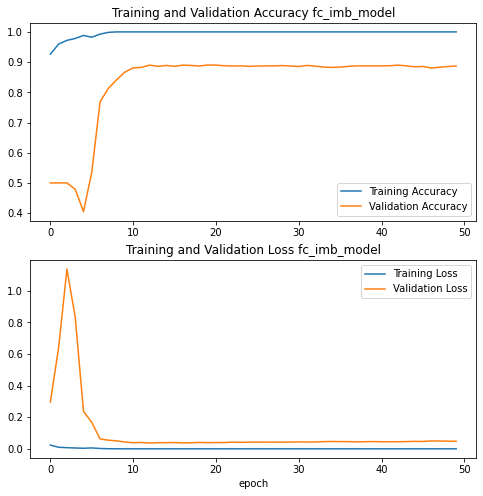

In [ ]:
show_results(fc_imb_model_history, name='fc_imb_model')

In [ ]:
get_correct_results(fc_imb_model, val_dataset)

total_correct:  tf.Tensor(1774, shape=(), dtype=int32)
total_correct_pos:  tf.Tensor(776, shape=(), dtype=int32)
total_correct_neg:  tf.Tensor(998, shape=(), dtype=int32)


# Pretrained Model Imbalanced Data

## Config and Load Data

In [ ]:
train_imgs_path = get_img_path_and_labels(TRAIN_PATH, num_pos=-1)
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs_path[0], train_imgs_path[1]))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  9778
POSSITVE CLASS:  586
NEGATIVE CLASS:  9192


In [ ]:
val_imgs_path = get_img_path_and_labels(VAL_PATH, num_pos=-1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs_path[0],val_imgs_path[1]))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  2000
POSSITVE CLASS:  1000
NEGATIVE CLASS:  1000


## Build Model 

In [ ]:
pret_model = build_model(input_shape= (IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL), weights='imagenet', final_act='sigmoid')

## Compile and Train 

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [ ]:
base_learning_rate = 0.0001
loss_func = tfa.losses.SigmoidFocalCrossEntropy()

pret_model.compile(loss=loss_func,
              optimizer = tf.keras.optimizers.Adam(base_learning_rate),
              metrics=METRICS)

In [ ]:
pret_model_history = pret_model.fit(train_dataset,
                         epochs=10,
                         validation_data=val_dataset)

Epoch 1/10
77/77 [==============================] - 33s 400ms/step - loss: 0.0062 - tp: 423.0000 - fp: 37.0000 - tn: 9155.0000 - fn: 163.0000 - accuracy: 0.9795 - precision: 0.9196 - recall: 0.7218 - auc: 0.9859 - prc: 0.8990 - val_loss: 0.6573 - val_tp: 9.0000 - val_fp: 0.0000e+00 - val_tn: 1000.0000 - val_fn: 991.0000 - val_accuracy: 0.5045 - val_precision: 1.0000 - val_recall: 0.0090 - val_auc: 0.7565 - val_prc: 0.8262
Epoch 2/10
77/77 [==============================] - 30s 393ms/step - loss: 2.1511e-04 - tp: 582.0000 - fp: 1.0000 - tn: 9191.0000 - fn: 4.0000 - accuracy: 0.9995 - precision: 0.9983 - recall: 0.9932 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0808 - val_tp: 605.0000 - val_fp: 0.0000e+00 - val_tn: 1000.0000 - val_fn: 395.0000 - val_accuracy: 0.8025 - val_precision: 1.0000 - val_recall: 0.6050 - val_auc: 0.9883 - val_prc: 0.9923
Epoch 3/10
77/77 [==============================] - 30s 391ms/step - loss: 2.5085e-05 - tp: 586.0000 - fp: 0.0000e+00 - tn: 9192.0000 - fn: 0.000

In [ ]:
pret_model.save(os.path.join(MODEL_PATH, 'pret_model.h5'))

## Evaluate Models 

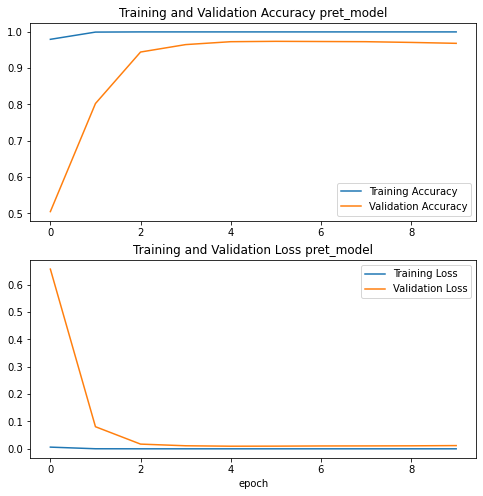

In [ ]:
show_results(pret_model_history, name='pret_model')

In [ ]:
get_correct_results(pret_model, val_dataset)

total_correct:  tf.Tensor(1937, shape=(), dtype=int32)
total_correct_pos:  tf.Tensor(939, shape=(), dtype=int32)
total_correct_neg:  tf.Tensor(998, shape=(), dtype=int32)


# Pretrained Model and Focal Loss Imbalanced Data

## Config and Load Data

In [ ]:
train_imgs_path = get_img_path_and_labels(TRAIN_PATH, num_pos=-1)
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs_path[0], train_imgs_path[1]))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  9778
POSSITVE CLASS:  586
NEGATIVE CLASS:  9192


In [ ]:
val_imgs_path = get_img_path_and_labels(VAL_PATH, num_pos=-1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs_path[0],val_imgs_path[1]))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  2000
POSSITVE CLASS:  1000
NEGATIVE CLASS:  1000


## Build Model 

In [ ]:
pret_fc_imb_model = build_model(input_shape= (IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL), final_act='sigmoid', weights='imagenet')

## Compile and Train 

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [ ]:
base_learning_rate = 0.0001
loss_func = tfa.losses.SigmoidFocalCrossEntropy()

pret_fc_imb_model.compile(loss=loss_func,
              optimizer = tf.keras.optimizers.Adam(base_learning_rate),
              metrics=METRICS)

In [ ]:
pret_fc_imb_model_history = pret_fc_imb_model.fit(train_dataset,
                         epochs=10,
                         validation_data=val_dataset)

Epoch 1/10
77/77 [==============================] - 33s 400ms/step - loss: 0.0077 - tp: 413.0000 - fp: 64.0000 - tn: 9128.0000 - fn: 173.0000 - accuracy: 0.9758 - precision: 0.8658 - recall: 0.7048 - auc: 0.9817 - prc: 0.8635 - val_loss: 0.6200 - val_tp: 34.0000 - val_fp: 0.0000e+00 - val_tn: 1000.0000 - val_fn: 966.0000 - val_accuracy: 0.5170 - val_precision: 1.0000 - val_recall: 0.0340 - val_auc: 0.7835 - val_prc: 0.8485
Epoch 2/10
77/77 [==============================] - 30s 394ms/step - loss: 4.2766e-04 - tp: 575.0000 - fp: 3.0000 - tn: 9189.0000 - fn: 11.0000 - accuracy: 0.9986 - precision: 0.9948 - recall: 0.9812 - auc: 1.0000 - prc: 0.9996 - val_loss: 0.0773 - val_tp: 636.0000 - val_fp: 0.0000e+00 - val_tn: 1000.0000 - val_fn: 364.0000 - val_accuracy: 0.8180 - val_precision: 1.0000 - val_recall: 0.6360 - val_auc: 0.9884 - val_prc: 0.9920
Epoch 3/10
77/77 [==============================] - 30s 392ms/step - loss: 3.2373e-05 - tp: 586.0000 - fp: 0.0000e+00 - tn: 9192.0000 - fn: 0.0

In [ ]:
pret_fc_imb_model.save(os.path.join(MODEL_PATH, 'pret_fc_imb_model.h5'))

## Evaluate Models 

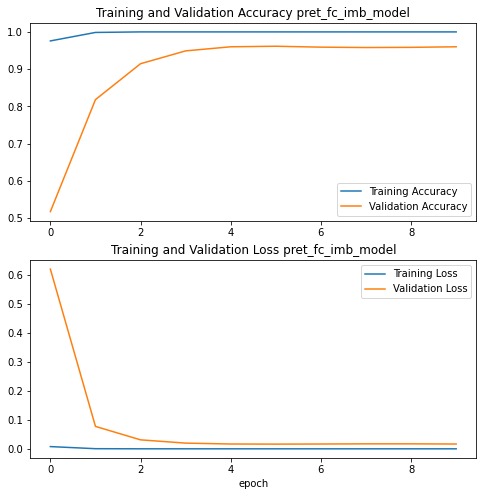

In [ ]:
show_results(pret_fc_imb_model_history, name='pret_fc_imb_model')

In [ ]:
get_correct_results(pret_fc_imb_model, val_dataset)

total_correct:  tf.Tensor(1920, shape=(), dtype=int32)
total_correct_pos:  tf.Tensor(920, shape=(), dtype=int32)
total_correct_neg:  tf.Tensor(1000, shape=(), dtype=int32)
